Assumptions 

* Covid data reported is accurate
* What about home tests not reported?
* 7 day moving average of daily cases is a valid proxy for the current number of infected individuals  
* Recovery rate is static 
* ~~It is fair to use the total population minus the number of infected individuals to compute the number of   susceptible individuals 
* We will compute the susceptible population by taking the total population and subtracting the total number of individuals who have covid or had covid over the past 60 days
* Total population is static
* The probability of recovery (recovery rate) is defined by what percentage of infected individuals will recover by the next time period (next day). If a single person recovers in ~10 days, then the probability of recovery is 10%.
* 10% recovery rate is valid and accurate enough for our purposes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter, FuncFormatter
import seaborn as sns
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from https://github.com/henrifroese/infectious_disease_modelling/blob/master/part_two.ipynb
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.ticklabel_format(useOffset=False, style='plain')
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

In [3]:
case_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us.csv'
df = pd.read_csv(case_data_url, parse_dates=['date'])

In [4]:
df = df[df.date > '2020-04-01']

In [5]:
df.drop(columns=['geoid', 'cases_avg_per_100k', 'deaths', 'deaths_avg', 'deaths_avg_per_100k'], inplace=True)

In [6]:
df.head()

,date,cases,cases_avg
72,2020-04-02,29717,22790.10
73,2020-04-03,32318,24932.29
74,2020-04-04,35099,26936.88
75,2020-04-05,25616,27951.16
76,2020-04-06,30916,29300.57


In [7]:
# constants
total_pop = 332403650
prob_recovery = .1

In [8]:
# This is the number of infected individuals at time period t + 1
df['next_cases_avg'] = -(df.cases_avg.diff(periods=-1)) + df.cases_avg

In [9]:
df.head()

,date,cases,cases_avg,next_cases_avg
72,2020-04-02,29717,22790.10,24932.29
73,2020-04-03,32318,24932.29,26936.88
74,2020-04-04,35099,26936.88,27951.16
75,2020-04-05,25616,27951.16,29300.57
76,2020-04-06,30916,29300.57,30136.30


### Compute our new Susceptible using vaccination data
Rules:
* Vaccines will be X% effective
* Vaccine efficacy will last for X months for full vaccinations
* Vaccine efficacy will last for X months for boosters
* Vaccine efficacy will last for X months for partial vaccinations
* Immunity will last for X months for those who have had covid

In [10]:
# Let's define the susceptible population to exclude people who have had covid in the last 60 days
df['immune_period'] = df.cases.rolling(60, min_periods=1).sum()

In [12]:
# pull in vaccination data set
owd_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
owd_df = pd.read_csv(owd_url, parse_dates=['date'])

# Limit the data to only United States
us_owd = owd_df[owd_df.location == 'United States']

# Only include features that are related to vaccines
vaccine_df = us_owd[[
    'date',
    'total_vaccinations',
    'people_vaccinated',
    'people_fully_vaccinated',
    'total_boosters',
    'new_vaccinations',
    'new_vaccinations_smoothed',
    'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred',
    'total_boosters_per_hundred',
    'new_people_vaccinated_smoothed',
    'new_people_vaccinated_smoothed_per_hundred'
]]

In [13]:
vaccine_df['new_people_fully_vaccinated'] = -(vaccine_df.people_fully_vaccinated.shift(1) - vaccine_df.people_fully_vaccinated)
vaccine_df['new_people_fully_vaccinated_smoothed'] = vaccine_df.new_people_fully_vaccinated.rolling(7, min_periods=1).mean()

In [14]:
vaccine_df['new_boosters'] = -(vaccine_df.total_boosters.shift(1) - vaccine_df.total_boosters)
vaccine_df['new_boosters_smoothed'] = vaccine_df.new_boosters.rolling(7, min_periods=1).mean()

In [15]:
# Still have a gap - partially vaccinated individuals
# Per https://ourworldindata.org/covid-vaccinations, at this time 77% of United States population
# has been vaccinated: 66% fully vaccinated, and 10% partially vaccinated
# We will compute the difference as a proportion of fully vaccinated, then apply this difference evenly across
# all instances of full vaccinations in the data set
prop_partial_vax = ((total_pop * .77) - (total_pop * .66)) / (total_pop * .77)
prop_partial_vax

0.14285714285714285

In [16]:
vaccine_df['people_partially_vaccinated'] = vaccine_df.new_people_fully_vaccinated * prop_partial_vax
vaccine_df['people_partially_vaccinated_smoothed'] = vaccine_df.people_partially_vaccinated.rolling(7, min_periods=1).mean()

In [17]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fm' % (x * 1e-6)

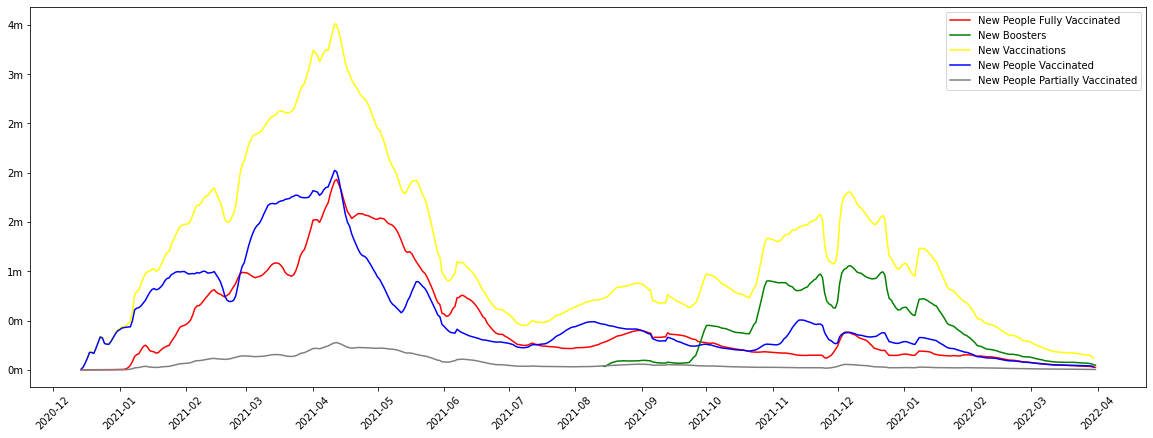

In [18]:
fig, ax = plt.subplots(figsize=(20,7))

# Plot the dates on the x axis and the percentage of people vaccinated on the y axis
ax.plot(vaccine_df.date, vaccine_df.new_people_fully_vaccinated_smoothed, color='red', label='New People Fully Vaccinated')
ax.plot(vaccine_df.date, vaccine_df.new_boosters_smoothed, color='green', label='New Boosters')
ax.plot(vaccine_df.date, vaccine_df.new_vaccinations_smoothed, color='yellow', label='New Vaccinations')
ax.plot(vaccine_df.date, vaccine_df.new_people_vaccinated_smoothed, color='blue', label='New People Vaccinated')
ax.plot(vaccine_df.date, vaccine_df.people_partially_vaccinated_smoothed, color='gray', label='New People Partially Vaccinated')

# Format the dates on the x axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', rotation=45)

# Format the y axis in millions
millionsFormatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(millionsFormatter)
ax.yaxis.set_minor_formatter(NullFormatter())

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

In [19]:
# merge vaccination data set to main dataframe
merge_df = pd.merge(df, vaccine_df, how='left', left_on='date', right_on='date')

In [20]:
merge_df = merge_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna(''))

In [21]:
# compute Susceptible population
vax_effectiveness = .75 # 75% effectiveness
vax_duration = 182 # lasts for 6 months
booster_duration = 182 # also lasts for 6 months
partial_vax_duration = 90 # Partially vaccinated last for 3 months

# Multiply the vaccine effectiveness by the number of vaccinated individuals over a rolling 6 month window
merge_df['vax_coverage'] = vax_effectiveness * merge_df.new_people_fully_vaccinated_smoothed.rolling(vax_duration, min_periods=1).sum()

# Multiply the vaccine effectiveness by the number of boosted individuals over a rolling 6 month window
merge_df['booster_coverage'] = vax_effectiveness * merge_df.new_boosters.rolling(booster_duration, min_periods=1).sum()

merge_df['partial_coverage'] = vax_effectiveness * merge_df.people_partially_vaccinated.rolling(partial_vax_duration, min_periods=1).sum()

# Immune is defined by those who are covered by vaccines, added to the number of currently or recently infected
merge_df['immune'] = merge_df.vax_coverage + merge_df.partial_coverage + merge_df.booster_coverage + merge_df.immune_period

Future enhancements:
* Incorporate age groups into susceptible population
* Make the vaccination effectiveness wane over time

Could look at demographic data of the US to partition the total population into sub-groups, then use case data that includes age groups, etc and factor that into the susceptible population

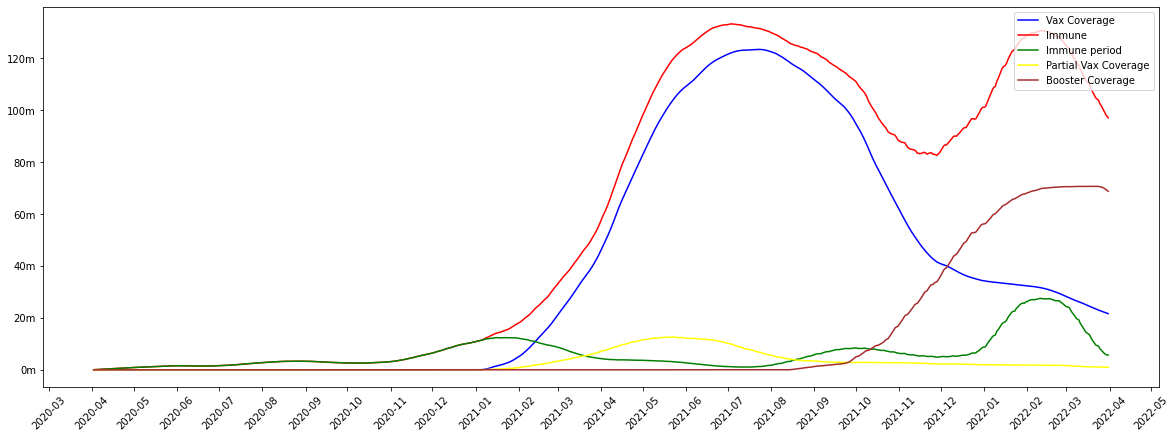

In [59]:
fig, ax = plt.subplots(figsize=(20,7))

# Plot the dates on the x axis and the percentage of people vaccinated on the y axis
ax.plot(merge_df.date, merge_df.vax_coverage, color='blue', label='Vax Coverage')
ax.plot(merge_df.date, merge_df.immune, color='red', label='Immune')
ax.plot(merge_df.date, merge_df.immune_period, color='green', label='Immune period')
ax.plot(merge_df.date, merge_df.partial_coverage, color='yellow', label='Partial Vax Coverage')
ax.plot(merge_df.date, merge_df.booster_coverage, color='brown', label='Booster Coverage')

# Format the dates on the x axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', rotation=45)

# Format the y axis in millions
millionsFormatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(millionsFormatter)
ax.yaxis.set_minor_formatter(NullFormatter())

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

Explanation of the above graph:
* Immune Period represents the number of people who have covid or have had covid in the past 60 days
* Vax Coverage represents the number of people who have been vaccinated in the past 6 months
* Booster Coverage represents the number of people who have received a booster shot in the past 6 months
* Partial Vax Coverage represents the number of people who have been partially vaccinated in the past 4 months
* Immune represents the Immune Period + Vax Coverage + Booster Coverage + Partial Vax Coverage, or the number of people who should be immune at that time

In [23]:
def get_prob_contact_spread(cases_avg, next_cases_avg, immune=0):
    '''
    SIR Model implementation, where we are solving for the probability of contact times
    the probability of spread.
    '''
    inner = cases_avg / total_pop * (total_pop - immune)
    return next_cases_avg / inner + prob_recovery * cases_avg / inner - cases_avg / inner

In [24]:
merge_df['prob_contact_spread'] = merge_df.apply(
    lambda x: get_prob_contact_spread(x.cases_avg, x.next_cases_avg, x.immune), axis=1
)

In [25]:
# R Zero: probability of contact times probability of spread, divided by probability of recovery
merge_df['r_zero'] = merge_df.prob_contact_spread / prob_recovery

In [26]:
# 14 day moving average for a smoother visualization. Shows trends instead of just being noisy.
merge_df['r_zero_ma'] = merge_df.r_zero.rolling(14, min_periods=1).mean()

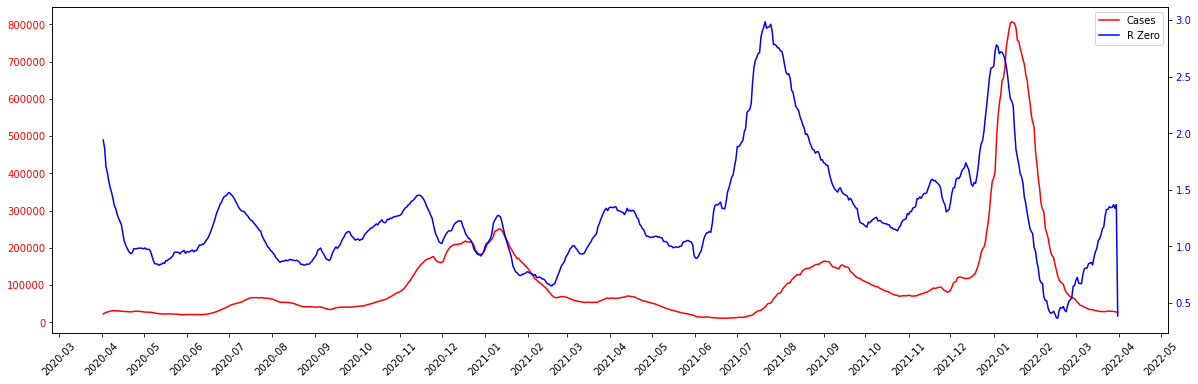

In [27]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(merge_df.date, merge_df.cases_avg, color='red', label='Cases')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()

ax2.plot(merge_df.date, merge_df.r_zero_ma, color='blue', label='R Zero')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

Explanation of the above visualization:

We are plotting the moving average of cases against the computed R Zero at that point in time.
The purpose of this is to see how the two correlate. We would expect an increase in R Zero to correlate with an increase in cases, and vice versa.

Do we expect a 1:1 correlation between these two? Do discrepancies imply that we are not computing the R Zero perfectly?

I believe this is accounted for by the susceptible population. It may be accurate to state that a higher R Zero is necessary to spread COVID when the susceptible population is lower.

In [28]:
merge_df.head()

,date,cases,cases_avg,next_cases_avg,immune_period,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,...,new_boosters_smoothed,people_partially_vaccinated,people_partially_vaccinated_smoothed,vax_coverage,booster_coverage,partial_coverage,immune,prob_contact_spread,r_zero,r_zero_ma
0,2020-04-02,29717,22790.10,24932.29,29717.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29717.0,0.194014,1.940139,1.940139
1,2020-04-03,32318,24932.29,26936.88,62035.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62035.0,0.180435,1.804350,1.872244
2,2020-04-04,35099,26936.88,27951.16,97134.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,97134.0,0.137694,1.376942,1.707144
3,2020-04-05,25616,27951.16,29300.57,122750.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,122750.0,0.148332,1.483322,1.651188
4,2020-04-06,30916,29300.57,30136.30,153666.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,153666.0,0.128582,1.285821,1.578115


# Visualize the Susceptible, Exposed, Infected, Recovered

In [29]:
infections = merge_df.cases_avg.tolist()
r_zero = merge_df.r_zero.tolist()

In [30]:
def deriv(y, t, N, gamma, delta):
    t = int(t)
    S, E, R = y
    I = infections[t]
    RO = r_zero[t]
    beta = RO * gamma
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    # dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dRdt

In [31]:
N = total_pop
D = 10.0 # infections lasts ten days
gamma = 1.0 / D
delta = 1.0 / 3.0  # incubation period of three days
# R_0 = 5.0
# beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, R0 = N-1, 1, 0  # initial conditions: one exposed

In [32]:
t = np.arange(len(infections), dtype=np.int16)
y0 = S0, E0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, gamma, delta))
S, E, R = ret.T

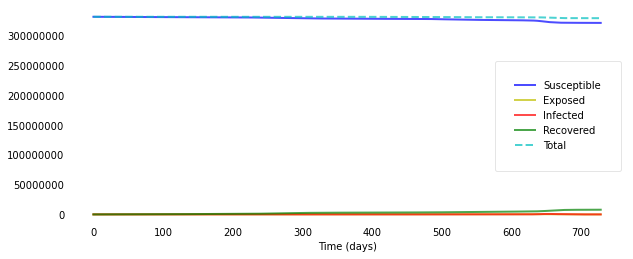

In [33]:
plotseird(t, S, E, infections, R)

# Visualizing Variant Data

In [34]:
variant_url = 'https://data.chhs.ca.gov/dataset/52e4aa7a-2ea3-4bfd-8cd6-7d653db1ee74/resource/d7f9acfa-b113-4cbc-9abc-91e707efc08a/download/covid19_variants.csv'
variants = pd.read_csv(variant_url, parse_dates=['date'])

In [35]:
variants.head()

,date,area,area_type,variant_name,specimens,percentage,specimens_7d_avg,percentage_7d_avg
0,2021-01-01,California,State,Epsilon,27.0,46.55,NaN,NaN
1,2021-01-01,California,State,Other,29.0,50.00,NaN,NaN
2,2021-01-01,California,State,Alpha,1.0,1.72,NaN,NaN
3,2021-01-01,California,State,Omicron,1.0,1.72,NaN,NaN
4,2021-01-01,California,State,Beta,0.0,0.00,NaN,NaN


In [36]:
# We are interested in the percentage of each variant for a given day
# So we group by the date and variant, then average the percentage
grouped_variants = variants.groupby(['date', 'variant_name'])['percentage'].mean().reset_index()

In [37]:
grouped_variants.head()

,date,variant_name,percentage
0,2021-01-01,Alpha,1.72
1,2021-01-01,Beta,0.00
2,2021-01-01,Delta,0.00
3,2021-01-01,Epsilon,46.55
4,2021-01-01,Gamma,0.00


In [38]:
# Remove the 'Total' variant, since it is unnecessary
grouped_variants = grouped_variants[grouped_variants.variant_name != 'Total']

In [39]:
# To play nicer with the area plot, we pivot the datat so that each variant is a feature (column)
# and the variant's percentage is the value.
# The 'x' axis of the data is still the date field.
pivot = grouped_variants.pivot(index='date', columns='variant_name', values='percentage')

In [40]:
pivot.head()

variant_name,Alpha,Beta,Delta,Epsilon,Gamma,Lambda,Mu,Omicron,Other
date,,,,,,,,,
2021-01-01,1.72,0.0,0.00,46.55,0.00,0.0,0.0,1.72,50.00
2021-01-02,5.88,0.0,0.98,41.18,0.00,0.0,0.0,0.98,50.98
2021-01-03,1.89,0.0,0.76,43.56,0.38,0.0,0.0,0.38,53.03
2021-01-04,0.40,0.0,0.40,53.95,0.00,0.0,0.0,0.00,45.25
2021-01-05,2.07,0.0,0.00,52.07,0.00,0.0,0.0,0.00,45.85


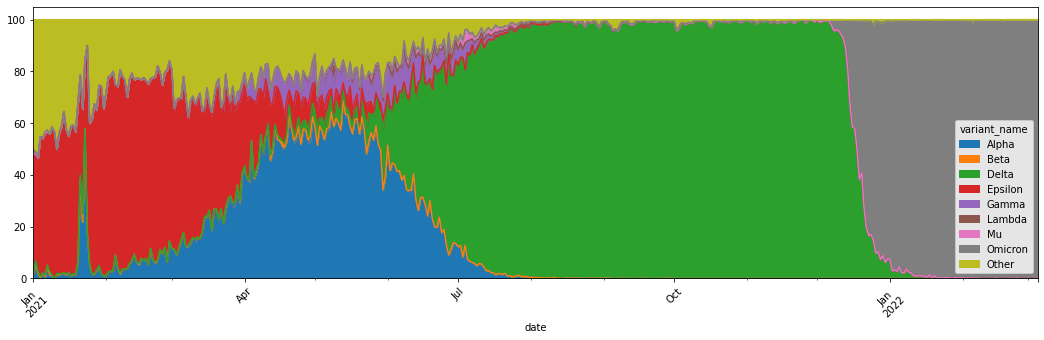

In [41]:
pivot.plot.area(figsize=(18,5), rot=45)

In [42]:
# Hypothesis: Covid variant has a significant impact on R Zero

In [43]:
# Create arbitrary score for variant
delta_score = 10
omicron_score = 20
all_others = 1

In [44]:
def apply_score(variant_name):
    if variant_name == 'Omicron':
        return omicron_score
    if variant_name == 'Delta':
        return delta_score
    return all_others

In [45]:
grouped_variants['score'] = grouped_variants.percentage / 100 * grouped_variants.variant_name.apply(apply_score)

In [46]:
grouped_variants

,date,variant_name,percentage,score
0,2021-01-01,Alpha,1.72,0.0172
1,2021-01-01,Beta,0.00,0.0000
2,2021-01-01,Delta,0.00,0.0000
3,2021-01-01,Epsilon,46.55,0.4655
4,2021-01-01,Gamma,0.00,0.0000
...,...,...,...,...
4284,2022-03-05,Gamma,0.00,0.0000
4285,2022-03-05,Lambda,0.00,0.0000
4286,2022-03-05,Mu,0.00,0.0000
4287,2022-03-05,Omicron,100.00,20.0000


In [47]:
daily_scores = grouped_variants.groupby('date')['score'].sum().reset_index()

In [48]:
daily_scores['date'] = pd.to_datetime(daily_scores.date)

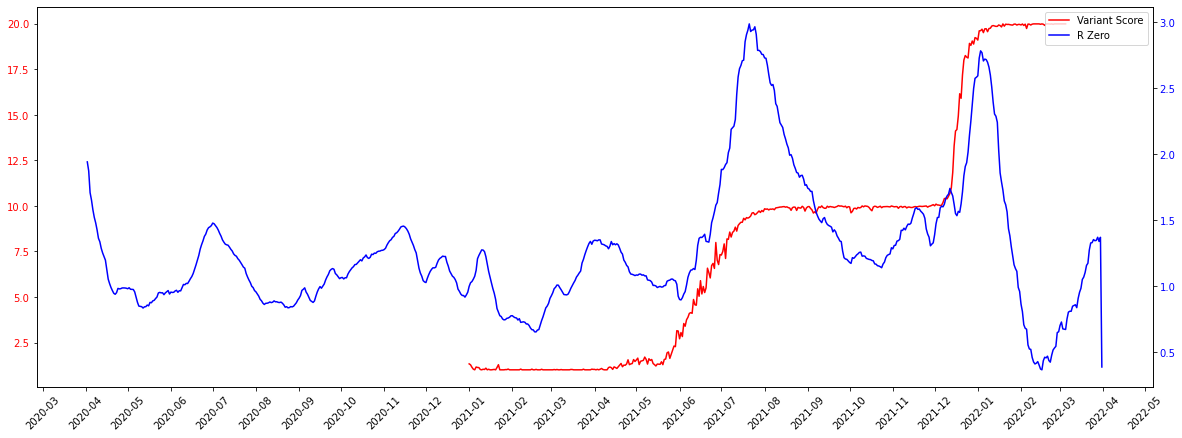

In [49]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(daily_scores.date, daily_scores.score, color='red', label='Variant Score')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()

ax2.plot(df.date, merge_df.r_zero_ma, color='blue', label='R Zero')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

Explanation of the above chart:

The variant score is the result of an arbitrary number assigned to each variant, where omicron is a higher number than delta, and delta is a higher number than all other variants, then this number is applied to the variant dataset to show the prevalance/potency of certain variants or combinations of variants at a specific moment in time. The purpose of this score is to have something to correlate with the R zero visually to see if spikes in R zero correlate to the introduction of new variants, specifically delta and omicron.

In [50]:
# Next: Look at vaccination data
# Update: Vaccination data has been incorporated into Susceptible in the SIR model

In [51]:
# Also next: look at https://colab.research.google.com/github/hf2000510/infectious_disease_modelling/blob/master/part_two.ipynb#scrollTo=8j_amELsSZ4n.
# Fit existing covid data to derive the number of exposed, infected, recovered, and susceptible individuals

In [52]:
# Fit data to a variation of the SIR model, like the SEIR model to see if we can get a more accurate R Zero
# Update: The SIR model has been updated to better model the behaviors of covid

In [53]:
# Look at mobility data

In [54]:
# Look at splitting out the probability of spread from the probability of contact

In [55]:
# Look at SVI

In [56]:
# Look at building a network model
# Either geographically, or socially (who interacts in person with who)

In [57]:
# How do we model/explain the surges in cases?  Is that a network/proximity thing?
# Are there certain factors or behaviors we can target?